In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import numpy as np

In [5]:
import pandas as pd
import numpy as np

In [6]:
import keras
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [7]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Attention

In [8]:
from keras.layers import *
from keras.models import *
from keras import backend as K

In [9]:
from sklearn.model_selection import train_test_split


In [10]:
gameData = pd.read_csv("/content/drive/Shareddrives/CS221 Project/Data/EngineeredScheduleData.csv")

In [11]:
timezones = {"Portland Trail Blazers" : "Pacific", "Sacramento Kings" : "Pacific", "Golden State Warriors" : "Pacific", "Los Angeles Clippers" : "Pacific", "Los Angeles Lakers" : "Pacific", "Utah Jazz" : "Mountain", "Denver Nuggets" : "Mountain", "Phoenix Suns" : "Mountain", "Minnesota Timberwolves":"Central","Milwaukee Bucks":"Central", "Chicago Bulls":"Central", "Oklahoma City Thunder":"Central", "Memphis Grizzlies":"Central", "Minnesota Timberwolves":"Central", "New Orleans Pelicans":"Central","Dallas Mavericks":"Central", "San Antonio Spurs":"Central", "Houston Rockets":"Central"}

In [12]:
for team in gameData['Home'].unique():
  if team not in timezones:
    timezones[team] = 'Eastern'

In [13]:
timezones['New Orleans Hornets'] = 'Central'

In [14]:
timezones

{'Portland Trail Blazers': 'Pacific',
 'Sacramento Kings': 'Pacific',
 'Golden State Warriors': 'Pacific',
 'Los Angeles Clippers': 'Pacific',
 'Los Angeles Lakers': 'Pacific',
 'Utah Jazz': 'Mountain',
 'Denver Nuggets': 'Mountain',
 'Phoenix Suns': 'Mountain',
 'Minnesota Timberwolves': 'Central',
 'Milwaukee Bucks': 'Central',
 'Chicago Bulls': 'Central',
 'Oklahoma City Thunder': 'Central',
 'Memphis Grizzlies': 'Central',
 'New Orleans Pelicans': 'Central',
 'Dallas Mavericks': 'Central',
 'San Antonio Spurs': 'Central',
 'Houston Rockets': 'Central',
 'New York Knicks': 'Eastern',
 'Cleveland Cavaliers': 'Eastern',
 'Washington Wizards': 'Eastern',
 'Orlando Magic': 'Eastern',
 'Indiana Pacers': 'Eastern',
 'Charlotte Bobcats': 'Eastern',
 'New Jersey Nets': 'Eastern',
 'Miami Heat': 'Eastern',
 'Toronto Raptors': 'Eastern',
 'Atlanta Hawks': 'Eastern',
 'Detroit Pistons': 'Eastern',
 'New Orleans Hornets': 'Central',
 'Boston Celtics': 'Eastern',
 'Philadelphia 76ers': 'Eastern'

In [15]:
gameData['Time Zone'] = gameData['Home'].map(timezones)

In [16]:
gameData['Time Zone'].replace(['Pacific', 'Mountain', 'Central', 'Eastern'],
                        [0, 1, 2, 3], inplace=True)

In [17]:
gameData.head()

,Unnamed: 0,Date,Start (ET),Visitor,Visitor Points,Home,Home Points,OT,Arena,Visitor Miles,Home Miles,Time Zone
0,0,2011-12-25,12:00p,Boston Celtics,104,New York Knicks,106,None,Madison Square Garden (IV),0.0,0.0,3
1,1,2011-12-25,2:30p,Miami Heat,105,Dallas Mavericks,94,None,American Airlines Center,0.0,0.0,2
2,2,2011-12-25,5:00p,Chicago Bulls,88,Los Angeles Lakers,87,None,STAPLES Center,0.0,0.0,0
3,3,2011-12-25,8:00p,Orlando Magic,89,Oklahoma City Thunder,97,None,Chesapeake Energy Arena,0.0,0.0,2
4,4,2011-12-25,10:30p,Los Angeles Clippers,105,Golden State Warriors,86,None,Oracle Arena,0.0,0.0,0


In [18]:
spreadData = pd.read_csv("/content/drive/Shareddrives/CS221 Project/Data/rawSpreadData.csv")

In [19]:
spreadData.head()

,game_id,date,sport,bet_type,away,home,away_line,home_line
0,20141005_nba_Sacramento_Toronto,20141005,nba,spread,Sacramento,Toronto,3.5,-3.5
1,20141006_nba_Philadelphia_Boston,20141006,nba,spread,Philadelphia,Boston,4.5,-4.5
2,20141006_nba_New Orleans_Atlanta,20141006,nba,spread,New Orleans,Atlanta,1.5,-1.5
3,20141006_nba_Washington_Chicago,20141006,nba,spread,Washington,Chicago,5.5,-5.5
4,20141006_nba_Denver_L.A. Lakers,20141006,nba,spread,Denver,L.A. Lakers,NaN,NaN


In [20]:
teams1 = (list(spreadData['home'].unique())[:-9])
teams1.sort()
teams2 = list(gameData['Home'].unique())
teams2.sort()
teamMap = dict(zip(teams1,teams2))

In [21]:
gameData["Home Spread"] = 0
gameData["Away Spread"] = 0
gameData["Spread Exists"] = False

In [22]:
for i in range(len(spreadData)):
  row = (spreadData.iloc[i])
  date = str(row['date'])[:4] + '-' + str(row['date'])[4:6] + '-' + str(row['date'])[6:]
  homeStart = row['home']
  homeStart = homeStart.replace("L.A.","Los Angeles")
  homeSpread = row["home_line"]
  awaySpread = row["away_line"]
  gameData.loc[(gameData['Date'] == date) & (gameData['Home'].str.startswith(homeStart)),"Home Spread"] = homeSpread
  gameData.loc[(gameData['Date'] == date) & (gameData['Home'].str.startswith(homeStart)),"Away Spread"] = awaySpread
  gameData.loc[(gameData['Date'] == date) & (gameData['Home'].str.startswith(homeStart)),"Spread Exists"] = True

In [23]:
gameData = gameData[gameData['Spread Exists'] == True]

In [24]:
gameData.head()

,Unnamed: 0,Date,Start (ET),Visitor,Visitor Points,Home,Home Points,OT,Arena,Visitor Miles,Home Miles,Time Zone,Home Spread,Away Spread,Spread Exists
3449,3449,2014-10-28,8:00p,Orlando Magic,84,New Orleans Pelicans,101,None,Smoothie King Center,858.113946,0.000000,2,-9.0,9.0,True
3450,3450,2014-10-28,8:00p,Dallas Mavericks,100,San Antonio Spurs,101,None,AT&T Center,1012.777910,0.000000,2,-3.5,3.5,True
3451,3451,2014-10-28,10:30p,Houston Rockets,108,Los Angeles Lakers,90,None,STAPLES Center,2687.867854,1940.636277,0,7.0,-7.0,True
3452,3452,2014-10-29,7:00p,Milwaukee Bucks,106,Charlotte Hornets,108,OT,Time Warner Cable Arena,1061.540275,0.000000,3,-8.0,8.0,True
3453,3453,2014-10-29,7:00p,Philadelphia 76ers,91,Indiana Pacers,103,None,Bankers Life Fieldhouse,1650.881420,1322.584762,3,-7.5,7.5,True


In [25]:
teamDfs = {}
### For every team, split data intpo each team and split that into home vs away
for team in gameData['Visitor'].unique():
  homeDf = (gameData[gameData['Home'] == team])
  awayDf = (gameData[gameData['Visitor'] == team])
  homeDf = homeDf.drop(columns = ['Unnamed: 0', 'Spread Exists'])
  awayDf = awayDf.drop(columns = ['Unnamed: 0', 'Spread Exists'])
  homeDf['Home Status'] = 1
  homeCover = (homeDf['Home Points'] - homeDf['Visitor Points']) > (-homeDf['Home Spread'])
  homeNotCover = (homeDf['Home Points'] - homeDf['Visitor Points']) < (-homeDf['Home Spread'])

  homeDf['Covered'] = (homeDf['Home Points'] - homeDf['Visitor Points']) > (-homeDf['Home Spread'])
  homeDf['trueNotCover'] = (homeDf['Home Points'] - homeDf['Visitor Points']) < (-homeDf['Home Spread'])
  homeDf['hasCover'] = homeDf['Covered'] | homeDf['trueNotCover']


  awayDf['Home Status'] = 0
  awayDf['Covered'] = awayDf['Visitor Points'] - awayDf['Home Points'] > -awayDf['Away Spread']
  awayDf['trueNotCover'] = awayDf['Visitor Points'] - awayDf['Home Points'] < -awayDf['Away Spread']
  awayDf['hasCover'] = awayDf['Covered'] | awayDf['trueNotCover']

  #awayDf['Covered'] = 1 if awayDf['Visitor Points'] - awayDf['Home Points'] > -awayDf['Away Spread'] else 0 if awayDf['Visitor Points'] - awayDf['Home Points'] < -awayDf['Away Spread'] else -1
  homeDf = homeDf.rename(columns = {"Home Miles" : "Miles Traveled", "Home Spread" : "Spread"})
  awayDf = awayDf.rename(columns = {"Visitor Miles" : "Miles Traveled", "Away Spread" : "Spread"})


  ###
  teamDf = pd.concat([homeDf,awayDf])
  teamDf = teamDf[teamDf['hasCover']]
  teamDf = teamDf.drop(columns = ['hasCover', 'trueNotCover', 'Away Spread', 'Home Spread', 'Visitor Miles', 'Home Miles'])
  teamDf['Date'] = pd.to_datetime(teamDf['Date'], format = "%Y-%m-%d")
  teamDf = teamDf.sort_values(by=['Date'], ascending=True)
  teamDf['Total Points'] = teamDf['Visitor Points'] + teamDf['Home Points']
  #teamDf = teamDf.drop(columns = ['Visitor Points', 'Home Points'])
  teamDf = teamDf.reset_index(drop=True)
  teamDf['Days from Last Game'] = 0
  teamDf['Change in Timezones'] = 0
  for i in reversed(range(0,len(teamDf))):
    if i != 0:
      teamDf.loc[i, 'OT'] = teamDf.loc[i-1, 'OT']
      ## Only get data from prev game
      teamDf.loc[i, 'Total Points'] = teamDf.loc[i-1, 'Total Points']
      teamDf.loc[i, 'Days from Last Game'] = (teamDf.loc[i, 'Date'] - teamDf.loc[i-1, 'Date']).days
      teamDf.loc[i, 'Change in Timezones'] = teamDf.loc[i,'Time Zone'] - teamDf.loc[i-1,'Time Zone']
    else:
      teamDf.loc[i, 'OT'] = None
      teamDf.loc[i, 'Total Points'] = 0
      teamDf.loc[i, 'Days from Last Game'] = 365
    teamDf.loc[i, 'Start (ET)'] = int(teamDf.loc[i, 'Start (ET)'].split(':')[0]) + int(teamDf.loc[i, 'Start (ET)'].split(':')[1][0:2])/60
  teamDf = teamDf.rename(columns = {'OT' : 'Previous Game OT', 'Total Points' : 'Previous Game Points'})
  teamDf['Covered'] = teamDf['Covered'].astype(int)
  teamDf['Previous Game OT'] = (teamDf['Previous Game OT'] == 'OT').astype(int)
  teamDf['Label'] = teamDf['Covered']
  teamDf = teamDf.drop(columns = ['Covered', 'Time Zone'])
  for i in range(len(teamDf)):
    teamDf.loc[i,'Date']=teamDf.loc[i,'Date'].timestamp()
  #teamDf = teamDf.astype('float32')
  teamDf = teamDf.dropna()
  teamDfs[team] = teamDf




In [26]:
testDf = teamDfs["Orlando Magic"]

In [27]:
megaDf = pd.concat([teamDf[5:] for teamDf in teamDfs.values()])


In [29]:
print(len(megaDf))

13454


In [34]:
x = megaDf.drop(columns = ['Visitor', 'Visitor Points', 'Home Points', 'Home', 'Arena', 'Label'])
y = megaDf["Label"]

In [35]:
x = np.array(x)
y = np.array(y)

In [36]:
count_label_1 = y.sum()
count_label_0 = len(y) - count_label_1
print(count_label_1)
print(count_label_0)

6726
6728


In [37]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.66666, random_state=42)

In [38]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [46]:
def modelEval(x, y):
  # Model Evaluation
  y_pred = model.predict(x)
  accuracy = accuracy_score(y, y_pred)
  precision = precision_score(y, y_pred)
  recall = recall_score(y, y_pred)
  conf_matrix = confusion_matrix(y, y_pred)

  print(f'Accuracy: {accuracy}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'Confusion Matrix:\n{conf_matrix}')

  plt.hist(y_pred)
  plt.title("Distribution of predicted probabilites")
  plt.show()

  # Cross-Validation
  kf = KFold(n_splits=5, random_state=42, shuffle=True)
  cv_scores = cross_val_score(model, x, y, cv=kf)
  print(f'Cross-Validation Scores: {cv_scores}')
  print(f'Average CV Score: {np.mean(cv_scores)}')


Accuracy: 0.5031326324731867
Precision: 0.5031326324731867
Recall: 1.0
Confusion Matrix:
[[   0 4679]
 [   0 4738]]


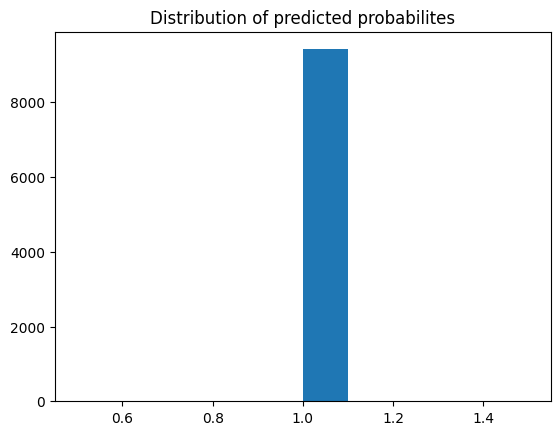

Cross-Validation Scores: [0.51380042 0.50265393 0.50823155 0.49548593 0.49548593]
Average CV Score: 0.5031315502546532


In [47]:
modelEval(X_train, y_train)

Accuracy: 0.4855018587360595
Precision: 0.4855018587360595
Recall: 1.0
Confusion Matrix:
[[  0 692]
 [  0 653]]


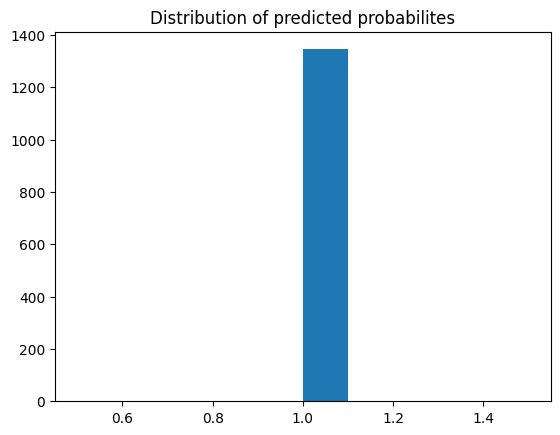

Cross-Validation Scores: [0.49442379 0.50185874 0.47211896 0.56877323 0.53531599]
Average CV Score: 0.5144981412639404


In [48]:
modelEval(X_val, y_val)

Accuracy: 0.4959138187221397
Precision: 0.4959138187221397
Recall: 1.0
Confusion Matrix:
[[   0 1357]
 [   0 1335]]


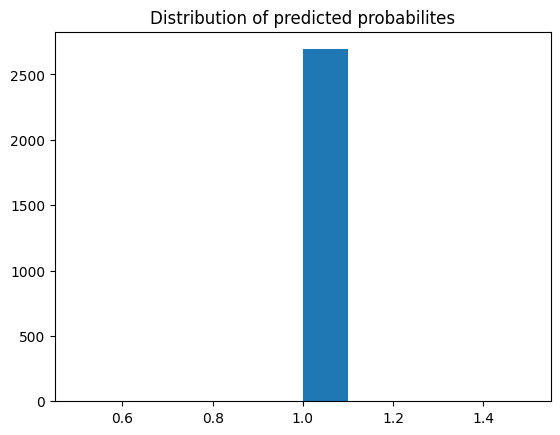

Cross-Validation Scores: [0.46938776 0.50463822 0.51115242 0.49442379 0.45910781]
Average CV Score: 0.4877419977791725


In [49]:
modelEval(X_test, y_test)